In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option("max_colwidth", 80)

<IPython.core.display.Javascript object>

In [4]:
# This is where our downloaded images and metadata live locally
DATA_PATH = Path.cwd().parent / "data" / "final" / "public"

<IPython.core.display.Javascript object>

In [5]:

train_metadata = pd.read_csv(DATA_PATH / "training_set_features.csv")
train_labels = pd.read_csv(DATA_PATH / "training_set_labels.csv")

<IPython.core.display.Javascript object>

In [6]:
train_metadata.head()

,image_id,storm_id,relative_time,ocean
0,abs_000,abs,0,2
1,abs_001,abs,1800,2
2,abs_002,abs,5400,2
3,abs_003,abs,17999,2
4,abs_004,abs,19799,2


<IPython.core.display.Javascript object>

In [7]:
train_metadata.shape

(70257, 4)

<IPython.core.display.Javascript object>

In [8]:
train_metadata.storm_id.nunique()

494

<IPython.core.display.Javascript object>

In [9]:
storm_counts = train_metadata.groupby("storm_id").size()
storm_counts.describe()

count    494.000000
mean     142.220648
std      123.151772
min        4.000000
25%       46.250000
50%      101.500000
75%      209.000000
max      648.000000
dtype: float64

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Number of Images per Storm')

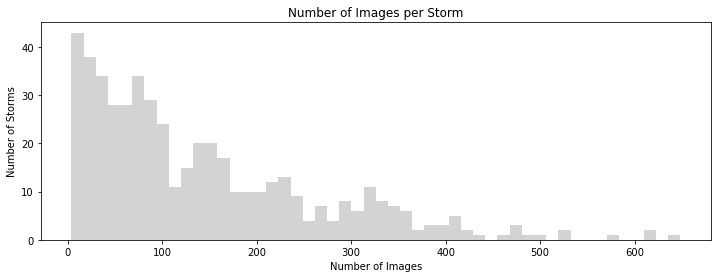

<IPython.core.display.Javascript object>

In [10]:

plt.figure(figsize=(12, 4))
plt.hist(storm_counts, bins=50, color="lightgray")
plt.xlabel("Number of Images")
plt.ylabel("Number of Storms")
plt.title("Number of Images per Storm")

In [11]:
train_metadata.groupby("ocean")["storm_id"].nunique()

ocean
1    264
2    230
Name: storm_id, dtype: int64

<IPython.core.display.Javascript object>

In [12]:
train_labels.head()

,image_id,wind_speed
0,abs_000,43
1,abs_001,44
2,abs_002,45
3,abs_003,52
4,abs_004,53


<IPython.core.display.Javascript object>

In [13]:

train_labels.describe()

,wind_speed
count,70257.000000
mean,50.344008
std,26.795277
min,15.000000
25%,30.000000
50%,43.000000
75%,62.000000
max,185.000000


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Distribution of Wind Speeds')

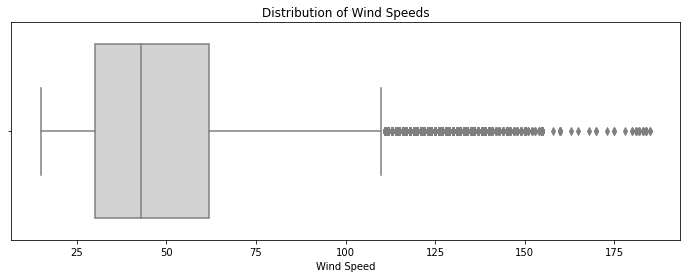

<IPython.core.display.Javascript object>

In [14]:
plt.figure(figsize=(12, 4))
sns.boxplot(x=train_labels.wind_speed, color="lightgray")
plt.xlabel("Wind Speed")
plt.title("Distribution of Wind Speeds")

In [15]:
# Merge train_metadata with train_labels on the image_id field
full_metadata = train_metadata.merge(train_labels, on="image_id")

<IPython.core.display.Javascript object>

In [16]:
def plot_wind_speeds(storm_id):
    storm = full_metadata[full_metadata.storm_id == storm_id]
    plt.figure(figsize=(12, 4))
    plt.scatter("relative_time", "wind_speed", data=storm, color="lightgray")
    plt.ticklabel_format(useOffset=False)
    plt.ylabel("Wind Speed")
    plt.title(f"Wind Speed over Relative Time: Storm {storm_id}")

<IPython.core.display.Javascript object>

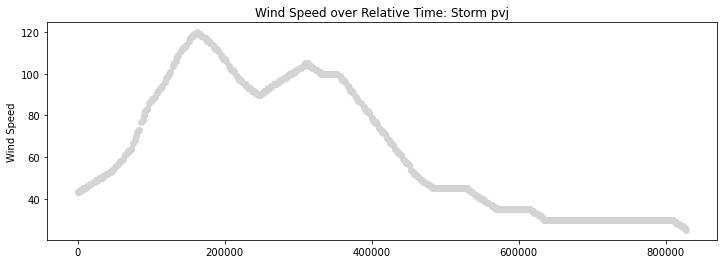

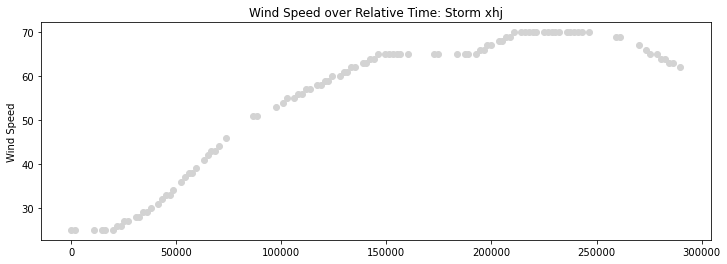

<IPython.core.display.Javascript object>

In [17]:
# Sample two random storms from full_metadata
for storm in full_metadata.storm_id.sample(2, random_state=40):
    plot_wind_speeds(storm)

In [18]:
# Path style access for pandas
import pandas_path

<IPython.core.display.Javascript object>

In [19]:
full_metadata["file_name"] = (
    DATA_PATH / "train" / full_metadata.image_id.path.with_suffix(".jpg")
)

<IPython.core.display.Javascript object>

In [20]:
from IPython.display import Image

<IPython.core.display.Javascript object>

In [21]:

def look_at_wind_speed(wind_speed):
    sample_img = full_metadata[full_metadata.wind_speed == wind_speed].file_name.iloc[0]
    return Image(str(sample_img))

<IPython.core.display.Javascript object>

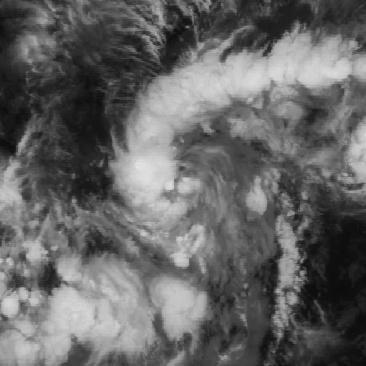

<IPython.core.display.Javascript object>

In [22]:

look_at_wind_speed(wind_speed=30)

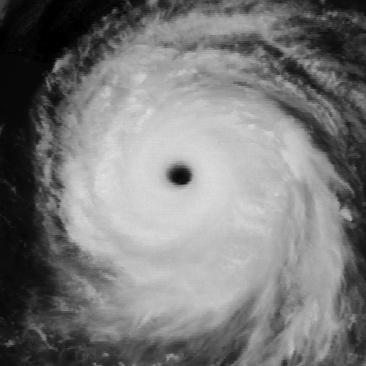

<IPython.core.display.Javascript object>

In [23]:
look_at_wind_speed(wind_speed=150)

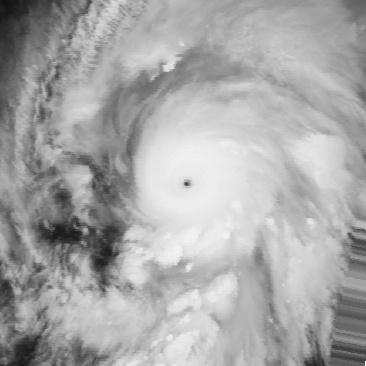

<IPython.core.display.Javascript object>

In [24]:
look_at_wind_speed(wind_speed=185)

In [25]:

from PIL import Image as pil_image

<IPython.core.display.Javascript object>

In [26]:
examples = [
    pil_image.open(full_metadata.iloc[i]["file_name"]).convert("RGB") for i in range(5)
]
for image in examples:
    print(image.size)

(366, 366)
(366, 366)
(366, 366)
(366, 366)
(366, 366)


<IPython.core.display.Javascript object>

In [27]:
# Add a temporary column for number of images per storm
images_per_storm = full_metadata.groupby("storm_id").size().to_frame("images_per_storm")
full_metadata = full_metadata.merge(images_per_storm, how="left", on="storm_id")

<IPython.core.display.Javascript object>

In [28]:
# Each storm is sorted by relative time
# Identify the final 20% of images per storm
full_metadata["pct_of_storm"] = (
    full_metadata.groupby("storm_id").cumcount() / full_metadata.images_per_storm
)
train = full_metadata[full_metadata.pct_of_storm < 0.8].drop(
    ["images_per_storm", "pct_of_storm"], axis=1
)
val = full_metadata[full_metadata.pct_of_storm >= 0.8].drop(
    ["images_per_storm", "pct_of_storm"], axis=1
)

<IPython.core.display.Javascript object>

In [29]:
# Confirm pct of images in the validation set is approximately 20%
len(val) / len(full_metadata) * 100

19.734688358455386

<IPython.core.display.Javascript object>

In [30]:
# Sample 10% to increase performance
train = train.sample(frac=0.1, replace=False, random_state=1)
val = val.sample(frac=0.1, replace=False, random_state=1)

<IPython.core.display.Javascript object>

In [31]:
train.shape

(5639, 6)

<IPython.core.display.Javascript object>

In [32]:
val.shape

(1386, 6)

<IPython.core.display.Javascript object>

In [33]:
# Separate features from labels
x_train = train.drop("wind_speed", axis=1)
y_train = train.wind_speed

x_val = val.drop("wind_speed", axis=1)
y_val = val.wind_speed

<IPython.core.display.Javascript object>

In [34]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

<IPython.core.display.Javascript object>

In [35]:
class DatasetWIND(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_train, y_train=None):
        self.data = x_train 
        self.label = y_train
        self.transform = transforms.Compose(
            [
                transforms.CenterCrop(128),
                transforms.ToTensor(),
                # All models expect the same normalization mean & std
                # https://pytorch.org/docs/stable/torchvision/models.html
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = pil_image.open(self.data.iloc[index]["file_name"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.iloc[index]["image_id"]
        if self.label is not None:
            label = self.label.iloc[index]
            sample = {"image_id": image_id, "image": image, "label": label}
        else:
            sample = {
                "image_id": image_id,
                "image": image,
            }
        return sample

<IPython.core.display.Javascript object>

In [36]:
from torch import nn

<IPython.core.display.Javascript object>

In [37]:
class RMSELoss(nn.Module):
    """Measures root mean square error."""

    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, true):
        return torch.sqrt(self.mse(pred, true))

<IPython.core.display.Javascript object>

In [38]:
import warnings

import pytorch_lightning as pl
from torch.utils.data import DataLoader
import torchvision.models as models
from tqdm import tqdm

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [109]:
class PretrainedWindModel(pl.LightningModule):
    def __init__(self, hparams):
        super(PretrainedWindModel, self).__init__()
        self.hparams = hparams
        self.learning_rate = self.hparams.get("lr", 2e-4)
        self.hidden_size = self.hparams.get("embedding_dim", 50)
        self.dropout = self.hparams.get("dropout", 0.1)
        self.max_epochs = self.hparams.get("max_epochs", 1)
        self.num_workers = self.hparams.get("num_workers", 0)
        self.batch_size = self.hparams.get("batch_size", 10)
        self.x_train = self.hparams.get("x_train")
        self.y_train = self.hparams.get("y_train")
        self.x_val = self.hparams.get("x_val")
        self.y_val = self.hparams.get("y_val")
        self.num_outputs = 1  # One prediction for regression

        # Where final model will be saved
        self.output_path = Path.cwd() / self.hparams.get("output_path", "model-outputs")
        self.output_path.mkdir(exist_ok=True)

        # Where TensorBoard logs will be saved
        self.log_path = Path.cwd() / self.hparams.get("log_path", "logs")
        self.log_path.mkdir(exist_ok=True)
        self.logger = pl.loggers.TensorBoardLogger(
            self.log_path, name="benchmark_model"
        )

        # Instantiate training and validation datasets
        self.train_dataset = DatasetWIND(self.x_train, self.y_train)
        self.val_dataset = DatasetWIND(self.x_val, self.y_val)
        self.model = self.prepare_model()

    def prepare_model(self):
        res_model = models.resnet152(pretrained=True)
        # Input size of 2048 for resnet152
        # https://pytorch.org/hub/pytorch_vision_resnet/
        res_model.fc = nn.Sequential(
            nn.Linear(2048, self.hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden_size, self.num_outputs),
        )
        
        return res_model

    def forward(self, image):
        return self.model(image)

    def training_step(self, batch, batch_idx):
        x = batch["image"]
        y = batch["label"]
        criterion = RMSELoss()
        # Switch to training mode
        loss = criterion(
            self.model.train().forward(x).squeeze(), y.type(torch.FloatTensor).cuda()
        )
        tensorboard_logs = {"train_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        x = batch["image"]
        y = batch["label"]
        criterion = RMSELoss()
        # Switch to evaluation mode
        loss = criterion(
            self.model.eval().forward(x).squeeze(), y.type(torch.FloatTensor).cuda()
        )
        tensorboard_logs = {"val_loss": loss}
        return {"batch_val_loss": loss, "log": tensorboard_logs}

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, num_workers=self.num_workers, batch_size=self.batch_size
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, num_workers=self.num_workers, batch_size=self.batch_size
        )

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate)

    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack(tuple(output["loss"] for output in outputs)).mean()
        return {
            "avg_epoch_train_loss": avg_train_loss,
            "progress_bar": {"avg_epoch_train_loss": avg_train_loss},
            "log": {"avg_epoch_train_loss": avg_train_loss},
        }

    def validation_epoch_end(self, outputs):
        avg_val_loss = torch.stack(
            tuple(output["batch_val_loss"] for output in outputs)
        ).mean()
        return {
            "avg_epoch_val_loss": avg_val_loss,
            "progress_bar": {"avg_epoch_val_loss": avg_val_loss},
            "log": {"avg_epoch_val_loss": avg_val_loss},
        }

    ## Convenience Methods ##

    def fit(self):
        self.trainer = pl.Trainer(
            max_epochs=self.max_epochs,
            default_root_dir=self.output_path,
            logger=self.logger,
            checkpoint_callback=pl.callbacks.ModelCheckpoint(
                filepath=self.output_path,
                monitor="avg_epoch_val_loss",
                mode="min",
                verbose=True,
                
            ),
            gradient_clip_val=self.hparams.get("gradient_clip_val", 1),
            num_sanity_val_steps=self.hparams.get("val_sanity_checks", 0),
            gpus=1,
        )
        self.trainer.fit(self)

    @torch.no_grad()
    def make_submission_frame(self, x_test):
        test_dataset = DatasetWIND(x_test)
        test_dataloader = DataLoader(
            test_dataset, num_workers=self.num_workers, batch_size=self.batch_size
        )
        submission_frame = pd.DataFrame(index=x_test.image_id, columns=["wind_speed"])
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            x = batch["image"]
            preds = self.eval().forward(x)
            submission_frame.loc[batch["image_id"], "wind_speed"] = (
                preds.detach().numpy().squeeze()
            )
        submission_frame.wind_speed = submission_frame.wind_speed.astype(float)
        return submission_frame
    
    def make_temporal_frame(self, x):
        test_dataset = DatasetWIND(x)
        test_dataloader = DataLoader(
            test_dataset, num_workers=self.num_workers, batch_size=self.batch_size
        )
        temporal_frame = pd.DataFrame(index=x.image_id, columns=["wind_speed"])
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            i = batch["image"]
            preds = self.eval().forward(i)
            
            temporal_frame.loc[batch["image_id"], "wind_speed"] = (
                preds.detach().numpy().squeeze()
            )
            
            
        temporal_frame.wind_speed = temporal_frame.wind_speed.astype(float)
        return temporal_frame

<IPython.core.display.Javascript object>

In [40]:
hparams = {
    # Required hparams
    "x_train": x_train,
    "y_train": y_train,
    "x_val": x_val,
    "y_val": y_val,
    # Optional hparams
    "lr": 2e-4,
    "embedding_dim": 100,
    "dropout": 0.1,
    "max_epochs": 4,
    "batch_size": 10,
    "num_workers": 0,
    "gradient_clip_val": 1,
    "val_sanity_checks": 0,
    "output_path": "model-outputs",
    "log_path": "logs",
}

<IPython.core.display.Javascript object>

In [240]:
storm_model = PretrainedWindModel(hparams=hparams)
storm_model.fit()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 58.3 M
---------------------------------
58.3 M    Trainable params
0         Non-trainable params
58.3 M    Total params


Epoch 0, global step 563: avg_epoch_val_loss reached 10.78231 (best 10.78231), saving model to "C:\Users\micha\data\model-outputs\epoch=0-step=563.ckpt" as top 1


Epoch 1, step 1127: avg_epoch_val_loss was not in top 1


Epoch 2, global step 1691: avg_epoch_val_loss reached 10.71586 (best 10.71586), saving model to "C:\Users\micha\data\model-outputs\epoch=2-step=1691.ckpt" as top 1


Epoch 3, step 2255: avg_epoch_val_loss was not in top 1


<IPython.core.display.Javascript object>

In [241]:

submission_format = pd.read_csv(
    DATA_PATH / "submission_format.csv", index_col="image_id"
)
submission_format.head()

,wind_speed
image_id,
acd_123,0
acd_124,0
acd_125,0
acd_126,0
acd_127,0


<IPython.core.display.Javascript object>

In [80]:
# Best checkpoint based on logs
best_checkpoint = str(Path("model-outputs") / "epoch=3-step=2255.ckpt")
example_model = PretrainedWindModel.load_from_checkpoint(best_checkpoint)

<IPython.core.display.Javascript object>

In [81]:

test_metadata = pd.read_csv(DATA_PATH / "test_set_features.csv")
test_metadata["file_name"] = (
    DATA_PATH / "test" / test_metadata.image_id.path.with_suffix(".jpg")
)

<IPython.core.display.Javascript object>

In [246]:
submission = example_model.make_submission_frame(test_metadata)

100%|████████████████████████████████████████████████████████████████████████████| 4438/4438 [1:10:01<00:00,  1.06it/s]


<IPython.core.display.Javascript object>

In [247]:
# Ensure submission indices match submission format
assert submission_format.index.equals(submission.index)

<IPython.core.display.Javascript object>

In [248]:

submission.head()

,wind_speed
image_id,
acd_123,24.006521
acd_124,23.980791
acd_125,23.636789
acd_126,24.723600
acd_127,24.144751


<IPython.core.display.Javascript object>

In [249]:
submission = submission.round().astype(int)
submission.head()

,wind_speed
image_id,
acd_123,24
acd_124,24
acd_125,24
acd_126,25
acd_127,24


<IPython.core.display.Javascript object>

In [250]:

submission.wind_speed.describe()

count    44377.000000
mean        45.638101
std         20.524731
min         17.000000
25%         30.000000
50%         39.000000
75%         55.000000
max        140.000000
Name: wind_speed, dtype: float64

<IPython.core.display.Javascript object>

In [251]:
submission.to_csv((DATA_PATH / "submission.csv"), index=True) 

<IPython.core.display.Javascript object>

In [121]:
mini_metadata = pd.read_csv(DATA_PATH / "mini_set_features.csv")
mini_metadata["file_name"] = (
    DATA_PATH / "mini" / mini_metadata.image_id.path.with_suffix(".jpg")
)
mini_metadata.head()

,image_id,storm_id,relative_time,ocean,file_name
0,aek_056,aek,201600,1,C:\Users\micha\data\final\public\mini\aek_056.jpg
1,aek_057,aek,205200,1,C:\Users\micha\data\final\public\mini\aek_057.jpg
2,aek_058,aek,208800,1,C:\Users\micha\data\final\public\mini\aek_058.jpg
3,aek_059,aek,212400,1,C:\Users\micha\data\final\public\mini\aek_059.jpg
4,aek_060,aek,216000,1,C:\Users\micha\data\final\public\mini\aek_060.jpg


<IPython.core.display.Javascript object>

In [122]:
best_checkpoint = str(Path("model-outputs") / "epoch=7-step=2255.ckpt")
example_model = PretrainedWindModel.load_from_checkpoint(best_checkpoint)

<IPython.core.display.Javascript object>

In [236]:
temporal = example_model.make_temporal_frame(mini_metadata)
temporal = temporal.merge( mini_metadata, 'left', left_index=True, right_on="image_id")
temporal = temporal.drop(columns=['ocean', 'file_name'])
temporal.head()

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.46s/it]


,wind_speed,image_id,storm_id,relative_time
0,36.971607,aek_056,aek,201600
1,33.198254,aek_057,aek,205200
2,31.887489,aek_058,aek,208800
3,35.926136,aek_059,aek,212400
4,40.490917,aek_060,aek,216000


<IPython.core.display.Javascript object>

In [229]:
temporal_shift= temporal.shift(1)
temporal_shift.drop(columns=['image_id'])

,wind_speed,storm_id,relative_time
0,NaN,NaN,NaN
1,36.971607,aek,201600.0
2,33.198254,aek,205200.0
3,31.887489,aek,208800.0
4,35.926136,aek,212400.0
...,...,...,...
64,39.835506,agb,23400.0
65,45.273098,agb,25200.0
66,45.069939,agb,27000.0
67,46.025196,agb,28799.0


<IPython.core.display.Javascript object>

In [230]:
temporal = temporal.merge(temporal_shift, 'inner', suffixes = ["","2"], right_index = True, left_index = True)
temporal['wind_speed2']= temporal['wind_speed2'].mask( temporal['storm_id'] != temporal['storm_id2'], -1)
temporal['relative_time2']= temporal['relative_time2'].mask( temporal['storm_id'] != temporal['storm_id2'], -1)
temporal = temporal.drop(columns=['image_id2', 'storm_id2'])
temporal.head()

,wind_speed,image_id,storm_id,relative_time,wind_speed2,relative_time2
0,36.971607,aek_056,aek,201600,0.000000,0.0
1,33.198254,aek_057,aek,205200,36.971607,201600.0
2,31.887489,aek_058,aek,208800,33.198254,205200.0
3,35.926136,aek_059,aek,212400,31.887489,208800.0
4,40.490917,aek_060,aek,216000,35.926136,212400.0


<IPython.core.display.Javascript object>

In [231]:
temporal_shift= temporal_shift.shift(1)
temporal = temporal.merge(temporal_shift, 'inner', suffixes = ["","3"], right_index = True, left_index = True)
temporal['wind_speed3']= temporal['wind_speed3'].mask( temporal['storm_id'] != temporal['storm_id3'], -1)
temporal['relative_time3']= temporal['relative_time3'].mask( temporal['storm_id'] != temporal['storm_id3'], -1)
temporal = temporal.drop(columns=['image_id3', 'storm_id3'])

<IPython.core.display.Javascript object>

In [232]:
temporal_shift= temporal_shift.shift(1)
temporal = temporal.merge(temporal_shift, 'inner', suffixes = ["","4"], right_index = True, left_index = True)
temporal['wind_speed4']= temporal['wind_speed4'].mask( temporal['storm_id'] != temporal['storm_id4'], -1)
temporal['relative_time4']= temporal['relative_time4'].mask( temporal['storm_id'] != temporal['storm_id4'], -1)
temporal = temporal.drop(columns=['image_id4', 'storm_id4'])

<IPython.core.display.Javascript object>

In [233]:
temporal_shift= temporal_shift.shift(1)
temporal = temporal.merge(temporal_shift, 'inner', suffixes = ["","5"], right_index = True, left_index = True)
temporal['wind_speed5']= temporal['wind_speed5'].mask( temporal['storm_id'] != temporal['storm_id5'], -1)
temporal['relative_time5']= temporal['relative_time5'].mask( temporal['storm_id'] != temporal['storm_id5'], -1)
temporal = temporal.drop(columns=['image_id5', 'storm_id5'])

<IPython.core.display.Javascript object>

In [235]:
temporal = temporal.drop(columns = ['storm_id'])
temporal.head()

,wind_speed,relative_time,wind_speed2,relative_time2,wind_speed3,relative_time3,wind_speed4,relative_time4,wind_speed5,relative_time5
52,32.637287,0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
53,33.969925,1800,32.637287,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
54,32.726208,3600,33.969925,1800.0,32.637287,0.0,0.000000,0.0,0.000000,0.0
55,36.133011,5400,32.726208,3600.0,33.969925,1800.0,32.637287,0.0,0.000000,0.0
56,35.966282,7200,36.133011,5400.0,32.726208,3600.0,33.969925,1800.0,32.637287,0.0
57,42.489666,10800,35.966282,7200.0,36.133011,5400.0,32.726208,3600.0,33.969925,1800.0
58,42.118149,12600,42.489666,10800.0,35.966282,7200.0,36.133011,5400.0,32.726208,3600.0
59,39.239021,14400,42.118149,12600.0,42.489666,10800.0,35.966282,7200.0,36.133011,5400.0
60,51.569832,16200,39.239021,14400.0,42.118149,12600.0,42.489666,10800.0,35.966282,7200.0
61,46.054985,18000,51.569832,16200.0,39.239021,14400.0,42.118149,12600.0,42.489666,10800.0


<IPython.core.display.Javascript object>

In [257]:
class TemporalWindModel(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,10)
        self.out = nn.Linear(10,1)
        self.lr = 0.01
        self.loss = RMSELoss()
    
    def forward(self,x):
        batch_size, _, _, _ = x.size()
        x = x.view(batch_size,-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(),lr = self.lr)
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.loss(logits,y)
        return loss

    def validation_step(self, valid_batch, batch_idx): 
        x, y = valid_batch 
        logits = self.forward(x) 
        loss = self.loss(logits, y) 
        


<IPython.core.display.Javascript object>

In [258]:
from pytorch_lightning import Trainer
model = TemporalWindModel()
trainer = Trainer(gpus=1)
trainer.fit(model, temporal)

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type     | Params
----------------------------------
0 | fc1  | Linear   | 512   
1 | fc2  | Linear   | 32.9 K
2 | fc3  | Linear   | 1.3 K 
3 | out  | Linear   | 11    
4 | loss | RMSELoss | 0     
----------------------------------
34.7 K    Trainable params
0         Non-trainable params
34.7 K    Total params
INFO:lightning:
  | Name | Type     | Params
----------------------------------
0 | fc1  | Linear   | 512   
1 | fc2  | Linear   | 32.9 K
2 | fc3  | Linear   | 1.3 K 
3 | out  | Linear   | 11    
4 | loss | RMSELoss | 0     
----------------------------------
34.7 K    Trainable params
0         Non-trainable params
34.7 K    Total params


ValueError: too many values to unpack (expected 2)

<IPython.core.display.Javascript object>